In [1]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

# Load data

In [2]:
X = pd.read_csv('./data/hcvdat0.csv', index_col=0).reset_index(drop=True)

# Pre-processing

In this first part, we need to change the ``category`` attribute of the data because we need it to be int. In addition, we change the ``Sex`` attribute from m/f to $0/1$. All the other attributes are already floats, so we keep them as they are.

> m $\rightarrow 0$ and f $\rightarrow 1$

> Blood donor $\rightarrow 0$, Suspect blood donor $\rightarrow 1$, Hepatitis $\rightarrow 2$, Fibrosis $\rightarrow 3$ and Cirrhosis $\rightarrow 4$

## Change the sex and category attributes

In [3]:
class_names = np.unique(X.Category)
X = X.replace({'Sex': {'f':1,'m':0}, 'Category':{'0=Blood Donor':0,'0s=suspect Blood Donor':1, '1=Hepatitis':2, '2=Fibrosis':3, '3=Cirrhosis':4}})

## Remove NaN values

In [4]:
X = X.dropna()

## Split X and y

In [5]:
y = X.Category
X = X.drop('Category', axis=1)

## Split the data in train and test split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

## Over sampling smaller categories

In [7]:
#On fait attention ici de ne pas toucher aux test sets
x_train_eq,y_train_eq = RandomOverSampler().fit_resample(x_train,y_train)

# Decision tree

## Build the tree

In [8]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

## Compute the accuracy of the tree

In [9]:
y_pred_train = clf.predict(x_train)
accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
print('Accuracy on the train set:', accuracy_train)

y_pred_test = clf.predict(x_test)
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
print('Accuracy on the test set:', accuracy_test)

Accuracy on the train set: 0.9546485260770975
Accuracy on the test set: 0.9256756756756757


## Visualise the tree

In [10]:
feature_names = X.columns
plot_tree = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, feature_names=feature_names, class_names=class_names)
graph = graphviz.Source(plot_tree)

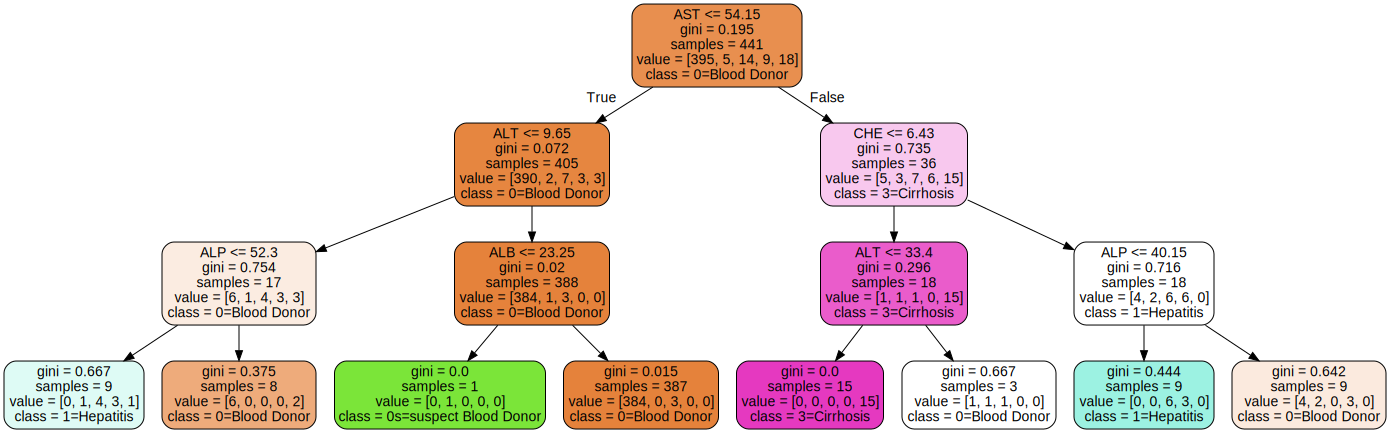

In [11]:
graph

Use ``graph.render('name of the graph', view=True)`` when one wants to save the graph in a pdf file in the same directory as the one containing this notebook.

## Bagging

In [12]:
Bagging = BaggingClassifier(n_estimators=100).fit(x_train,y_train)
Bagging.score(x_test,y_test)

0.9391891891891891

In [13]:
bagging_grid = {'max_samples':np.arange(0.1,1.1,0.1)}
bagging_cv = GridSearchCV(Bagging,bagging_grid,cv=4)
#bagging_cv.fit(x_train_eq,y_train_eq) #to train on the oversampled training set
bagging_cv.fit(x_train,y_train)
bagging_cv.best_params_

{'max_samples': 0.6}

In [14]:
bagging_cv.score(x_test, y_test)

0.9256756756756757

## Random forest

In [15]:
RF = RandomForestClassifier(n_estimators=100).fit(x_train,y_train)
RF.score(x_test, y_test)

0.9391891891891891

In [16]:
param_RF = {'max_samples':np.arange(0.1,1,0.1),'max_depth':np.arange(1,10)}
RF_cv = GridSearchCV(RF,param_grid=param_RF,cv=4)
#RF_cv.fit(x_train_eq,y_train_eq)
RF_cv.fit(x_train,y_train)
RF_cv.best_params_

{'max_depth': 6, 'max_samples': 0.9}

In [17]:
RF_cv.score(x_test,y_test)

0.9324324324324325

# SVM

## SVM Normal

In [18]:
%%time
clf_rbf = SVC(kernel='rbf',C=2.5)
clf_rbf.fit(x_train, y_train)

CPU times: user 9.98 ms, sys: 2.28 ms, total: 12.3 ms
Wall time: 11.6 ms


SVC(C=2.5)

In [19]:
clf_rbf.score(x_test, y_test)

0.9391891891891891

In [20]:
%%time
param_grid = {'C':np.arange(1,10,1)}
clf_rbf_cv = GridSearchCV(clf_rbf, param_grid,cv=4)
clf_rbf_cv.fit(x_train, y_train)
print(clf_rbf_cv.best_params_)

{'C': 9}
CPU times: user 406 ms, sys: 7.59 ms, total: 414 ms
Wall time: 441 ms


In [21]:
clf_rbf_cv.score(x_test, y_test)

0.9324324324324325

## One versus one classification

In [22]:
clf_ovo = SVC(decision_function_shape='ovo')
clf_ovo.fit(x_train, y_train)

SVC(decision_function_shape='ovo')

In [23]:
clf_ovo.score(x_test, y_test)

0.9256756756756757

## One versus rest classification

In [24]:
clf_ovr = SVC(decision_function_shape='ovr')
clf_ovr.fit(x_train, y_train)

SVC()

In [25]:
clf_ovr.score(x_test, y_test)

0.9256756756756757

We obtain the same results with the two different methods

# Neural Network

In [26]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import optimizers
from keras.utils.np_utils import to_categorical

In [99]:
sc = StandardScaler()
#x_k_train = sc.fit_transform(x_train)
x_k_train = np.array(x_train)
x_k_train = (x_k_train-np.mean(x_k_train,axis=1,keepdims=True))/np.std(x_k_train,axis=1,keepdims=True)
x_k_test = np.array(x_test)
y_k_train = to_categorical(y_train)
y_k_test = to_categorical(y_test)

x_k_train_eq = np.array(x_train_eq)
x_k_train_eq = (x_k_train_eq-np.mean(x_k_train_eq,axis=1,keepdims=True))/np.std(x_k_train_eq,axis=1,keepdims=True)
y_k_train_eq = to_categorical(y_train_eq)

In [111]:
model = Sequential()

model.add(Dense(300, activation='relu', input_dim=12))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [107]:
history = model.fit(x_k_train, y_k_train, batch_size = 2, epochs = 100, validation_data=(x_k_test, y_k_test), verbose=1)

Epoch 1/100
221/221 [==============================] - 1s 2ms/step - loss: 0.6570 - accuracy: 0.8342 - val_loss: 0.4318 - val_accuracy: 0.8919
Epoch 2/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5277 - accuracy: 0.8598 - val_loss: 0.3951 - val_accuracy: 0.8986
Epoch 3/100
221/221 [==============================] - 0s 2ms/step - loss: 0.3692 - accuracy: 0.9058 - val_loss: 0.3516 - val_accuracy: 0.9122
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 0.3951 - accuracy: 0.8827 - val_loss: 0.3466 - val_accuracy: 0.9122
Epoch 5/100
221/221 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8833 - val_loss: 0.3463 - val_accuracy: 0.9054
Epoch 6/100
221/221 [==============================] - 1s 3ms/step - loss: 0.3094 - accuracy: 0.9040 - val_loss: 0.3366 - val_accuracy: 0.9054
Epoch 7/100
221/221 [==============================] - 0s 2ms/step - loss: 0.2321 - accuracy: 0.9203 - val_loss: 0.3517 - val_accuracy: 0.9054

Epoch 58/100
221/221 [==============================] - 0s 2ms/step - loss: 0.0933 - accuracy: 0.9719 - val_loss: 0.3030 - val_accuracy: 0.9324
Epoch 59/100
221/221 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9615 - val_loss: 0.3044 - val_accuracy: 0.9392
Epoch 60/100
221/221 [==============================] - 0s 2ms/step - loss: 0.1073 - accuracy: 0.9514 - val_loss: 0.3040 - val_accuracy: 0.9392
Epoch 61/100
221/221 [==============================] - 0s 2ms/step - loss: 0.1334 - accuracy: 0.9438 - val_loss: 0.3003 - val_accuracy: 0.9324
Epoch 62/100
221/221 [==============================] - 0s 2ms/step - loss: 0.1118 - accuracy: 0.9529 - val_loss: 0.3053 - val_accuracy: 0.9324
Epoch 63/100
221/221 [==============================] - 0s 2ms/step - loss: 0.1045 - accuracy: 0.9594 - val_loss: 0.2966 - val_accuracy: 0.9324
Epoch 64/100
221/221 [==============================] - 0s 2ms/step - loss: 0.1068 - accuracy: 0.9625 - val_loss: 0.3084 - val_accuracy:

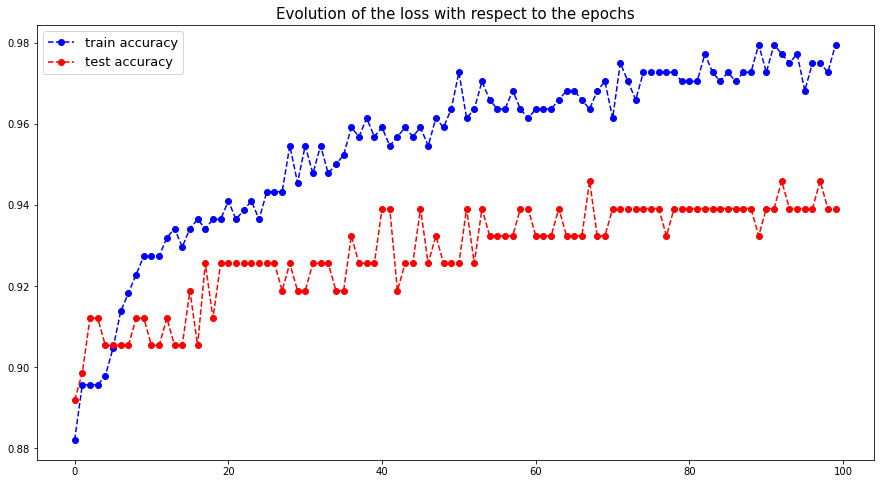

In [108]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
plt.figure(figsize=(15,8))
plt.plot(loss, c='b', marker='o', linestyle='--', label='train accuracy')
plt.plot(val_loss, c='r', marker='o', linestyle='--', label='test accuracy')
plt.title('Evolution of the accuracy with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()